# A/B Testing Analysis for Marketing Campaign

This notebook performs an A/B test analysis on the `marketing_AB.csv` dataset to evaluate the effectiveness of a new marketing campaign (group 'ad') against a public service announcement (group 'psa').

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
sns.set(style="whitegrid")

## 1. Data Loading and Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('marketing_AB.csv')

# Rename 'test group' to 'group' if it exists
if 'test group' in df.columns:
    df.rename(columns={'test group': 'group'}, inplace=True)
    print("Renamed 'test group' column to 'group'.")

# Convert 'converted' column to integer (0 or 1)
df['converted'] = df['converted'].astype(int)
print("Converted 'converted' column to integer type.")

print("DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()

Renamed 'test group' column to 'group'.
Converted 'converted' column to integer type.
DataFrame Head:
   Unnamed: 0  user id group  converted  total ads most ads day  most ads hour
0           0  1069124    ad          0        130       Monday             20
1           1  1119715    ad          0         93      Tuesday             22
2           2  1144181    ad          0         21      Tuesday             18
3           3  1435133    ad          0        355      Tuesday             10
4           4  1015700    ad          0        276       Friday             14

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   group          588101 non-null  object
 3   converted      588101 non-null  int64 
 4   total ads      588101 non-nu

## 2. Conversion Rate Calculation

In [3]:
# Calculate conversion rates for each group
conversion_rates = df.groupby('group')['converted'].mean() * 100
print("Conversion Rates:")
print(conversion_rates)

Conversion Rates:
group
ad     2.554656
psa    1.785411
Name: converted, dtype: float64


## 3. Visualization

C:\Users\Aniruddh Parashar\AppData\Local\Temp\ipykernel_13012\2657321517.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette='viridis')


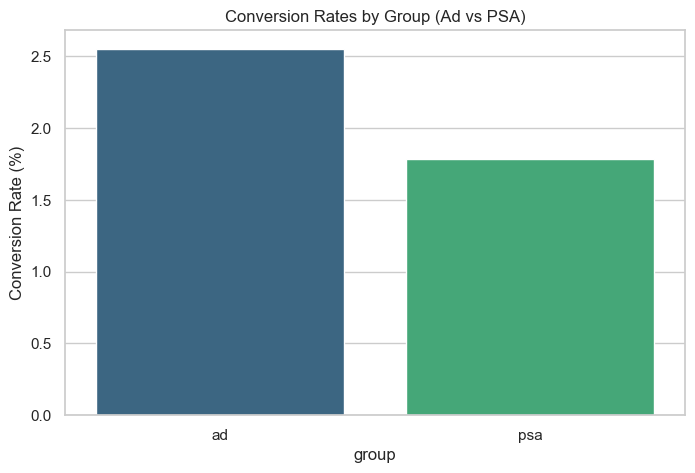

In [4]:
# Plot conversion rates
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette='viridis')
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion Rates by Group (Ad vs PSA)")
plt.show()

## 4. Hypothesis Testing (Two-sample t-test)

In [5]:
# Define control and treatment groups
control_group = df[df['group'] == 'psa']['converted']
treatment_group = df[df['group'] == 'ad']['converted']

# Perform two-sample t-test
if len(control_group) > 1 and len(treatment_group) > 1:
    t_stat, p_val = stats.ttest_ind(treatment_group, control_group)
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.4f}")

    print("\n### Interpretation")
    print("- Null Hypothesis (H0): No difference in conversion between 'ad' and 'psa' groups.")
    print("- Alternative Hypothesis (H1): The 'ad' campaign has a different conversion rate than 'psa'.")

    if p_val < 0.05:
        print("\nConclusion: P-value < 0.05. Reject Null Hypothesis. The 'ad' campaign had a statistically significant impact on conversions compared to 'psa'.")
    else:
        print("\nConclusion: P-value >= 0.05. Fail to Reject Null Hypothesis. The 'ad' campaign did not have a statistically significant impact on conversions compared to 'psa'.")
else:
    print("Not enough samples in one or both groups to perform a t-test. Check group sizes.")

T-statistic: 7.3704
P-value: 0.0000

### Interpretation
- Null Hypothesis (H0): No difference in conversion between 'ad' and 'psa' groups.
- Alternative Hypothesis (H1): The 'ad' campaign has a different conversion rate than 'psa'.

Conclusion: P-value < 0.05. Reject Null Hypothesis. The 'ad' campaign had a statistically significant impact on conversions compared to 'psa'.


## 5. Key Insights

In [6]:

# Self-contained A/B stats block: re-derives inputs to avoid NameError
import pandas as pd
import numpy as np
from math import sqrt, asin
import os

# Try to reuse existing df if present; else load from CSV
try:
    df  # type: ignore
except NameError:
    path_candidates = [
        "marketing_AB.csv",
        "/mnt/data/marketing_AB.csv",
        "./data/marketing_AB.csv"
    ]
    for p in path_candidates:
        if os.path.exists(p):
            df = pd.read_csv(p)
            break
    else:
        raise FileNotFoundError("Could not locate marketing_AB.csv")

# Normalize columns
cols_lower = {c.lower(): c for c in df.columns}
group_col = cols_lower.get("group") or cols_lower.get("test group")
conv_col = cols_lower.get("converted")
if group_col is None:
    raise KeyError("Could not find 'group' or 'test group' column in the dataset.")
if conv_col is None:
    raise KeyError("Could not find 'converted' column in the dataset.")

df = df.rename(columns={group_col: "group"})
df["group"] = df["group"].astype(str).str.lower().str.strip()
df[conv_col] = pd.to_numeric(df[conv_col], errors="coerce").fillna(0).astype(int)

# Filter
ad = df[df["group"] == "ad"]
psa = df[df["group"] == "psa"]

# Stats
p1 = ad[conv_col].mean()
p2 = psa[conv_col].mean()
n1 = len(ad)
n2 = len(psa)
diff = p1 - p2

# 95% CI for difference (normal approx)
se = (p1*(1-p1)/n1 + p2*(1-p2)/n2) ** 0.5
z = 1.96
ci_diff = (diff - z*se, diff + z*se)

def cohens_h(a, b):
    return 2 * (asin(np.sqrt(a)) - asin(np.sqrt(b)))

h = cohens_h(p1, p2)

print(f"ad conversion: {p1:.4%} (n={n1})")
print(f"psa conversion: {p2:.4%} (n={n2})")
print(f"Difference in conversion: {diff:.4%}")
print(f"95% CI for difference: {ci_diff[0]:.4%} to {ci_diff[1]:.4%}")
print(f"Cohen's h: {h:.3f}")


ad conversion: 2.5547% (n=564577)
psa conversion: 1.7854% (n=23524)
Difference in conversion: 0.7692%
95% CI for difference: 0.5951% to 0.9434%
Cohen's h: 0.053
